<a href="https://colab.research.google.com/github/dhuanca/Pycon2022/blob/main/SegmentacionPyconBolivia2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelo Segmentación cliente 

In [3]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

Un sparkSession es un punto de entrada para programar Spark con Dataframes (DataFrame API)

El método builder es el constructor de instancias SparkSession

https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.SparkSession.html

In [5]:
spark = SparkSession.builder.appName("Segmentacion").getOrCreate()

Leer de un HDFS que se encuentra en la ruta /user/curso/ el archivo csv: churn_Operacion_2.csv

El Schema se infiere

Para el caso de Colab, se lee de la carpeta content

In [20]:
df_telco = spark.read.csv('/content/churn_Operacion_2.csv', header=True, inferSchema=True)

In [21]:
df_telco.show(1)

+-----+--------+----------+-------------+-------------------+----------------+----------------------+------------------+----------------+-----------------+------------------+----------------+-----------------+--------------------+------------------+-------------------+-------------------+-----------------+------------------+------------------------------+-------+
|state| account| area_code| phone_number| international_plan| voice_mail_plan| number_vmail_messages| total_day_minutes| total_day_calls| total_day_charge| total_eve_minutes| total_eve_calls| total_eve_charge| total_night_minutes| total_night_calls| total_night_charge| total_intl_minutes| total_intl_calls| total_intl_charge| number_customer_service_calls| churn.|
+-----+--------+----------+-------------+-------------------+----------------+----------------------+------------------+----------------+-----------------+------------------+----------------+-----------------+--------------------+------------------+-------------------

### ¿Que es el esquema?

Es la metadata asociada al dataFrame **df_telco**

In [22]:
df_telco.printSchema()

root
 |-- state: string (nullable = true)
 |--  account: double (nullable = true)
 |--  area_code: double (nullable = true)
 |--  phone_number: string (nullable = true)
 |--  international_plan: string (nullable = true)
 |--  voice_mail_plan: string (nullable = true)
 |--  number_vmail_messages: double (nullable = true)
 |--  total_day_minutes: double (nullable = true)
 |--  total_day_calls: double (nullable = true)
 |--  total_day_charge: double (nullable = true)
 |--  total_eve_minutes: double (nullable = true)
 |--  total_eve_calls: double (nullable = true)
 |--  total_eve_charge: double (nullable = true)
 |--  total_night_minutes: double (nullable = true)
 |--  total_night_calls: double (nullable = true)
 |--  total_night_charge: double (nullable = true)
 |--  total_intl_minutes: double (nullable = true)
 |--  total_intl_calls: double (nullable = true)
 |--  total_intl_charge: double (nullable = true)
 |--  number_customer_service_calls: double (nullable = true)
 |--  churn.: strin

### ¿Por qué es importante definir un schema?

Es importante porque los modelos por si mismos no identifican si una variable es cuantitativa o cualitativa. Por ejemplo: si la ciudades de Cochabamba y Santa Cruz por los números 1 y 2. Estos valores son númericos? Una computadora los reconoce como numéricos si no se indentifica como texto que es lo que realmente son (cualitativos)


In [23]:
from pyspark.sql.types import StructType, StructField, StringType, LongType, IntegerType, DoubleType, FloatType

In [24]:
Mischema = StructType(
    [
        StructField('state', StringType(), True),
        StructField('account', StringType(), True),
        StructField('area_code', StringType(), True),
        StructField('phone_number', StringType(), True),
        StructField('international_plan', StringType(), True),
        StructField('voice_mail_plan', StringType(), True),       
        StructField("number_vmail_messages",  DoubleType(), True),
        StructField('total_day_minutes', DoubleType(), True), 
        StructField('total_day_calls', DoubleType(), True),
        StructField('total_day_charge', DoubleType(), True),
        StructField('total_eve_minutes', DoubleType(), True),
        StructField('total_eve_calls', DoubleType(), True),
        StructField('total_eve_charge', DoubleType(), True),
        StructField('total_night_minutes', DoubleType(), True),
        StructField('total_night_calls', DoubleType(), True),
        StructField('total_night_charge', DoubleType(), True),
        StructField('total_intl_minutes', DoubleType(), True),
        StructField('total_intl_calls', DoubleType(), True),
        StructField('total_intl_charge', DoubleType(), True),
        StructField('number_customer_service_calls', DoubleType(), True),
        StructField('churn.', StringType(), True)       
    ]
)

Re leer el dataframe con el schema acordado

In [25]:
df_telco = spark.read.csv('/content/churn_Operacion_2.csv', header=True, schema=Mischema)

La variable "churn." tiene un punto en la parte final

In [26]:
df_telco = df_telco.withColumnRenamed('churn.','churn')

### Explorar datos

Ordenar por columnas 

¿Cuáles son las 5 personas que menos reclamos y las 5 personas que mas reclaman?

Ascendente

In [31]:
df_telco.sort('number_customer_service_calls')[['number_customer_service_calls', 'phone_number']].show(5)

+-----------------------------+------------+
|number_customer_service_calls|phone_number|
+-----------------------------+------------+
|                          0.0|    396-5800|
|                          0.0|    395-2854|
|                          0.0|    358-1958|
|                          0.0|    358-1921|
|                          0.0|    343-4696|
+-----------------------------+------------+
only showing top 5 rows



Descendente

In [32]:
from pyspark.sql import functions as F

In [33]:
df_telco.sort(F.desc('number_customer_service_calls'))[['number_customer_service_calls', 'phone_number']].show(5)

+-----------------------------+------------+
|number_customer_service_calls|phone_number|
+-----------------------------+------------+
|                          9.0|    416-6886|
|                          9.0|    416-2778|
|                          8.0|    333-8822|
|                          8.0|    371-1727|
|                          7.0|    397-9184|
+-----------------------------+------------+
only showing top 5 rows



Para verificar el dominio de variables cualitativas se usan funciones de agrupación

¿Cuál es la distribución por area?

¿Cual es la distribucion de la tenencia de un plan de llamadas internacionales?

¿Cual es la media de mensajes de texto y llamadas al call center por estado?


In [15]:
df_telco.groupBy(F.col('area_code')).count().show()

+---------+-----+
|area_code|count|
+---------+-----+
|      408|  838|
|      510|  840|
|      415| 1655|
+---------+-----+



In [16]:
df_telco.groupBy(F.col('international_plan')).count().show()

+------------------+-----+
|international_plan|count|
+------------------+-----+
|                no| 3010|
|               yes|  323|
+------------------+-----+



In [17]:
df_telco[['state','number_vmail_messages','number_customer_service_calls']].groupBy(F.col('state')).avg().show()

+-----+--------------------------+----------------------------------+
|state|avg(number_vmail_messages)|avg(number_customer_service_calls)|
+-----+--------------------------+----------------------------------+
|   AZ|                   9.46875|                           1.59375|
|   SC|         8.683333333333334|                1.5833333333333333|
|   LA|         7.901960784313726|                1.5686274509803921|
|   MN|         8.261904761904763|                1.5476190476190477|
|   NJ|         9.191176470588236|                1.6764705882352942|
|   DC|          9.74074074074074|                1.3518518518518519|
|   OR|          6.17948717948718|                1.7307692307692308|
|   VA|         7.038961038961039|                1.5974025974025974|
|   RI|         7.323076923076923|                1.4153846153846155|
|   WY|          6.51948051948052|                1.4415584415584415|
|   KY|                       7.0|                1.7118644067796611|
|   NH|         8.26

In [151]:
df_telco.groupBy(F.col('voice_mail_plan')).count().show()

+---------------+-----+
|voice_mail_plan|count|
+---------------+-----+
|             no| 2411|
|            yes|  922|
+---------------+-----+



¿Como puedo graficar?

Hay varias fomas de hacerlo. Una es crer un resumen con Spark para llevarlo a Pandas y usar alguna libreria de graficación.

Para ello se usa el metodo **toPandas**

In [35]:
df_telco_pandas = df_telco[['churn','number_customer_service_calls']].groupBy(F.col('churn')).avg().toPandas()

In [36]:
type(df_telco_pandas)

pandas.core.frame.DataFrame

In [37]:
type(df_telco)

pyspark.sql.dataframe.DataFrame

In [39]:
df_telco_pandas

,churn,avg(number_customer_service_calls)
0,False.,1.449825
1,True.,2.229814


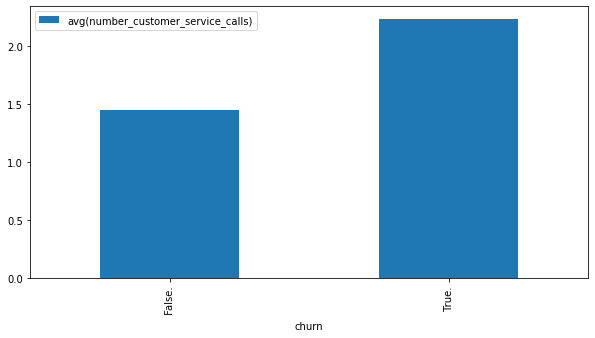

In [38]:
df_telco_pandas.plot.bar('churn', figsize=(10,5))
plt.show()

In [40]:
df_telco_pandas = df_telco[['churn','total_day_minutes']].groupBy(F.col('churn')).avg().toPandas()

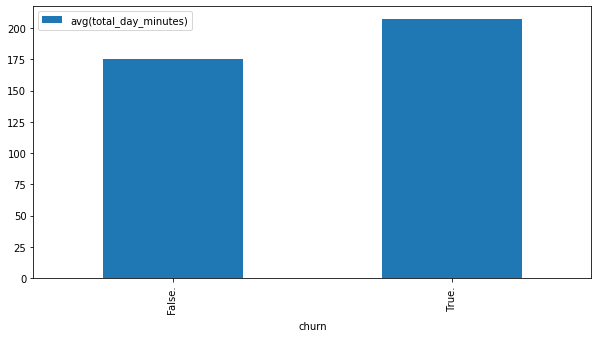

In [41]:
df_telco_pandas.plot.bar('churn', figsize=(10,5))
plt.show()

##   Transformaciones para refinar datos

###   Renonbrar columnas

La variable churn. contiene un punto al final que podemos eliminarlo

In [ ]:
# ya se hizo lineas arriba
# df_telco = df_telco.withColumnRenamed('churn.','churn')

In [42]:
df_telco.columns

['state',
 'account',
 'area_code',
 'phone_number',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'churn']

### Eliminación de valores nulos

In [44]:
df_telco_describe = df_telco.describe().toPandas()

In [45]:
df_telco_describe

,summary,state,account,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,count,3333,3333,3333,3333,3333,3333,3333,3333,3333,...,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333
1,mean,None,101.06480648064806,437.18241824182417,None,None,None,8.099009900990099,179.77509750975116,100.43564356435644,...,100.11431143114311,17.083540354035392,200.87203720372048,100.10771077107711,9.039324932493264,10.237293729372933,4.4794479447944795,2.764581458145804,1.5628562856285628,None
2,stddev,None,39.822105928595676,42.37129048560661,None,None,None,13.688365372038598,54.46738920237146,20.069084207300893,...,19.92262529394312,4.310667643110347,50.57384701365836,19.568609346058544,2.275872837660027,2.791839548408416,2.4612142705460953,0.7537726126630451,1.3154910448664752,None
3,min,AK,1,408,327-1058,no,no,0.0,0.0,0.0,...,0.0,0.0,23.2,33.0,1.04,0.0,0.0,0.0,0.0,False.
4,max,WY,99,510,422-9964,yes,yes,51.0,350.8,165.0,...,170.0,30.91,395.0,175.0,17.77,20.0,20.0,5.4,9.0,True.


In [46]:
df_telco_summary = df_telco.summary().toPandas()

In [47]:
df_telco_summary

,summary,state,account,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,count,3333,3333,3333,3333,3333,3333,3333,3333,3333,...,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333
1,mean,None,101.06480648064806,437.18241824182417,None,None,None,8.099009900990099,179.77509750975116,100.43564356435644,...,100.11431143114311,17.083540354035392,200.87203720372048,100.10771077107711,9.039324932493264,10.237293729372933,4.4794479447944795,2.764581458145804,1.5628562856285628,None
2,stddev,None,39.822105928595676,42.37129048560661,None,None,None,13.688365372038598,54.46738920237146,20.069084207300893,...,19.92262529394312,4.310667643110347,50.57384701365836,19.568609346058544,2.275872837660027,2.791839548408416,2.4612142705460953,0.7537726126630451,1.3154910448664752,None
3,min,AK,1,408,327-1058,no,no,0.0,0.0,0.0,...,0.0,0.0,23.2,33.0,1.04,0.0,0.0,0.0,0.0,False.
4,25%,None,74.0,408.0,None,None,None,0.0,143.7,87.0,...,87.0,14.16,167.0,87.0,7.52,8.5,3.0,2.3,1.0,None
5,50%,None,101.0,415.0,None,None,None,0.0,179.4,101.0,...,100.0,17.12,201.2,100.0,9.05,10.3,4.0,2.78,1.0,None
6,75%,None,127.0,510.0,None,None,None,20.0,216.4,114.0,...,114.0,20.0,235.3,113.0,10.59,12.1,6.0,3.27,2.0,None
7,max,WY,99,510,422-9964,yes,yes,51.0,350.8,165.0,...,170.0,30.91,395.0,175.0,17.77,20.0,20.0,5.4,9.0,True.


In [48]:
final_df = df_telco.na.drop()

### Transformación de registros

En general para realizar una transformación a una columna se usa la función withColumn

* Borrar prosibles espacios vacios. Se usa la funcion **trim**

In [49]:
final_df.groupBy(F.col('churn')).count().show()

+-------+-----+
|  churn|count|
+-------+-----+
| False.| 2850|
|  True.|  483|
+-------+-----+



In [50]:
final_df = final_df.withColumn('churn', F.trim(final_df.churn))

In [51]:
final_df.groupBy(F.col('churn')).count().show()

+------+-----+
| churn|count|
+------+-----+
| True.|  483|
|False.| 2850|
+------+-----+



## Feature engineering

Se realiza una transformación de variables cualitativas.

Los modelos de ML no interpretan palabras o textos, estos deben ser convertidos a números.

Una de estas transformaciones es el one-hot-encoding

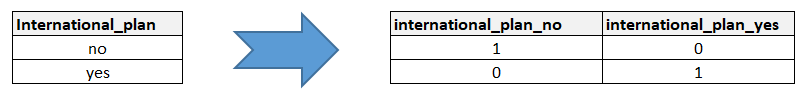

In [70]:
df_telco_final = final_df.select([
 'state',
 'area_code',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 "churn"])

Para realizar ingeniería de caracteristicas pyspark tienen una serie de herramientas disponibles en el modulo **feature**

**VectorAssembler** Es un transformador que combina una lista de columnas en un único vector columna. Es usado para combinar columnas originales con transformadas en un simple vector.

**OneHotEncoder** Realiza la transformación one-hot-encoding

**StringIndexer** Codifica una columna de etiquetas a una columna de etiquetas de números. El orden de asignación de etiquetas numéricas esta en función a la frecuencia de las etiquetas de texto. Significa que 0 corrresponde a la etiqueta mas frecuente y asi.


https://spark.apache.org/docs/latest/ml-features


In [120]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer

one hot encoding international_plan

In [121]:
international_plan_indexer = StringIndexer(inputCol='international_plan', outputCol= 'international_planIndex')

In [122]:
type(international_plan_indexer)

pyspark.ml.feature.StringIndexer

In [123]:
international_plan_encoder = OneHotEncoder(inputCol = 'international_planIndex', outputCol= 'international_planVec')

In [124]:
type(international_plan_encoder)

pyspark.ml.feature.OneHotEncoder

one hot encoding State

In [125]:
state_indexer = StringIndexer(inputCol= 'state', outputCol= 'stateIndex')

In [126]:
state_encoder = OneHotEncoder(inputCol = 'stateIndex', outputCol= 'stateVec')

one hot encoding area_code

In [127]:
area_code_indexer = StringIndexer(inputCol='area_code', outputCol= 'area_codeIndex')

In [128]:
area_code_encoder = OneHotEncoder(inputCol = 'area_codeIndex', outputCol= 'area_codeVec')

one hot encoding voice_mail_plan

In [129]:
voice_mail_plan_indexer = StringIndexer(inputCol='voice_mail_plan', outputCol= 'voice_mail_planIndex')

In [130]:
voice_mail_plan_encoder = OneHotEncoder(inputCol = 'voice_mail_planIndex', outputCol= 'voice_mail_planVec')

In [131]:
churn_indexer = StringIndexer(inputCol= 'churn', outputCol= 'churnIndex')

In [132]:
# 'stateVec',
assembler = VectorAssembler(inputCols = [ 'area_codeVec', 'international_planVec', 'voice_mail_planVec',
                                        'number_vmail_messages',
                                         'total_day_minutes',
                                         'total_day_calls',
                                         'total_day_charge',
                                         'total_eve_minutes',
                                         'total_eve_calls',
                                         'total_eve_charge',
                                         'total_night_minutes',
                                         'total_night_calls',
                                         'total_night_charge',
                                         'total_intl_minutes',
                                         'total_intl_calls',
                                         'total_intl_charge',
                                         'number_customer_service_calls'
                                        ], outputCol= 'features')

Seleccionando las variables que se usarán en el análisis cluster

In [133]:
df_telco_final.columns

['state',
 'area_code',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'churn']

In [134]:
#  Quitando la variable churn que sirve para un modelo de aprendizaje supervizado

df_telco_col_seg = df_telco_final.select([
 # 'state',
 'area_code',
 'international_plan',
 'voice_mail_plan',   
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls'])

## Modelado 

Debido a que el problema de negocio tiene que ver con la identificación de grupos, se usará un algoritmo de clustering que se basa en distancias con la finalidad de crear grupos que se convertiran en segmentos.

### Pipelines

Los ML Pipelines proveen un conjunto de APIS construidas sobre los DataFrames que ayudan a crear y tunear pipelines de ML.

Se pueden combinar multiples algoritmos en un simple pipeline.

- **DataFrame** Esta ML API usa dataframes Spark SQL, los cuales al igual que Pandas pueden almacenar diferentes tipos de datos. Ej: Un dataframe puede almacenar texto, vectores de caracteristicas, etiquetas verdadero/falso y predicciones.

- **Transformer**  Un transformer es un algoritmo que puede transformar un dataframe en otro dataframe. Ej: un modelo de ML es un transformer que transforma un dataframa con caracteristicas en un dataframe con predicciones.

- **Estimador** Un estimador es un algoritmo que puede ajustar sombre un dataframe para producir un transformer. Ej. Un algoritmo de aprendizaje es un estimador el cual entrega sobre un dataframe y produce un modelo

- **Pipeline** Un pipeline es una cadena de multiples transformaciones y estimadores juntos para especificar un flujo de trabajo ML.

## Componentes de un pipeline

En ML es común ejecutar una secuencia de algoritmos para procesar y aprender de los datos. Ej:

- Realizar un one hot encoding

MLlib representado como un flujo de Pipeline, el cual consiste de uns secuencia de PipelineStages (Estimadores y transformers) para ser ejecutados en un orden específico. 

Para los stage transformadores, el método transform() es llamado sobre el DataFrame. Para los stage estimadores, el método fit() es llamado.


https://spark.apache.org/docs/latest/ml-pipeline.html

https://spark.apache.org/docs/latest/ml-clustering.html

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.ClusteringEvaluator.html#pyspark.ml.evaluation.ClusteringEvaluator





In [135]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [136]:
from pyspark.ml import Pipeline

In [137]:
kmeans = KMeans().setK(5).setSeed(1)

In [138]:
pipeline = Pipeline(stages= [
    # state_indexer,
    area_code_indexer,
    international_plan_indexer,
    voice_mail_plan_indexer,
    # state_encoder,
    area_code_encoder,
    international_plan_encoder,
    voice_mail_plan_encoder,
    assembler, 
    kmeans])

In [139]:
train_data, test_data = df_telco_col_seg.randomSplit([0.7,0.3])

In [140]:
fit_model = pipeline.fit(train_data)

In [141]:
type(fit_model)

pyspark.ml.pipeline.PipelineModel

realizar clusterizaciones

In [142]:
predictions = fit_model.transform(test_data)

In [150]:
predictions.show(10)

+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+--------------+-----------------------+--------------------+-------------+---------------------+------------------+--------------------+----------+
|area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|area_codeIndex|international_planIndex|voice_mail_planIndex| area_codeVec|international_planVec|voice_mail_planVec|            features|prediction|
+---------+------------------+---------------+---------------------+--------------

In [155]:
predictions.sort(F.desc('voice_mail_plan')).show(5)

+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+--------------+-----------------------+--------------------+-------------+---------------------+------------------+--------------------+----------+
|area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|area_codeIndex|international_planIndex|voice_mail_planIndex| area_codeVec|international_planVec|voice_mail_planVec|            features|prediction|
+---------+------------------+---------------+---------------------+--------------

para observar de mejor manera se puede obtener una muestra y convertirlo en un dataframe Pandas

In [144]:
predictions_pandas = predictions.sample(fraction=0.5).toPandas()

In [145]:
predictions_pandas.head()

,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,total_intl_charge,number_customer_service_calls,area_codeIndex,international_planIndex,voice_mail_planIndex,area_codeVec,international_planVec,voice_mail_planVec,features,prediction
0,408,no,no,0.0,39.5,78.0,6.72,264.3,106.0,22.47,...,2.70,0.0,1.0,0.0,0.0,"(0.0, 1.0)",(1.0),(1.0),"[0.0, 1.0, 1.0, 1.0, 0.0, 39.5, 78.0, 6.72, 26...",0
1,408,no,no,0.0,54.8,92.0,9.32,173.0,103.0,14.71,...,2.03,1.0,1.0,0.0,0.0,"(0.0, 1.0)",(1.0),(1.0),"[0.0, 1.0, 1.0, 1.0, 0.0, 54.8, 92.0, 9.32, 17...",3
2,408,no,no,0.0,61.3,91.0,10.42,194.4,94.0,16.52,...,3.08,1.0,1.0,0.0,0.0,"(0.0, 1.0)",(1.0),(1.0),"[0.0, 1.0, 1.0, 1.0, 0.0, 61.3, 91.0, 10.42, 1...",0
3,408,no,no,0.0,61.6,117.0,10.47,77.1,85.0,6.55,...,2.21,4.0,1.0,0.0,0.0,"(0.0, 1.0)",(1.0),(1.0),"[0.0, 1.0, 1.0, 1.0, 0.0, 61.6, 117.0, 10.47, ...",3
4,408,no,no,0.0,69.1,117.0,11.75,136.3,100.0,11.59,...,1.70,1.0,1.0,0.0,0.0,"(0.0, 1.0)",(1.0),(1.0),"[0.0, 1.0, 1.0, 1.0, 0.0, 69.1, 117.0, 11.75, ...",3


In [146]:
predictions.groupBy(F.col('prediction')).count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  194|
|         3|  223|
|         4|  180|
|         2|  231|
|         0|  163|
+----------+-----+



In [147]:
predictions_pandas['prediction'].value_counts()

2    133
3    111
1     98
4     91
0     81
Name: prediction, dtype: int64

Evaluar mediante el coeficiente de Silhouette

El coeficiente Silhouette se encuentra entre - 1 y 1 siendo lo mejor 1 y lo peor -1, el valor 0 indica que los clusters estan sobreponiendo

In [148]:
evaluador = ClusteringEvaluator()

In [149]:
silhouette = evaluador.evaluate(predictions)
print("El coeficiente Silhouette usando distancias euclidianas al cuadrado es = " + str(silhouette))

El coeficiente Silhouette usando distancias euclidianas al cuadrado es = 0.2685616265850329
